### Imports

In [4]:
!pip install ultralytics transformers torch torchvision pillow matplotlib opencv-python
from tqdm import tqdm
import time

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import textwrap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.3 MB/s eta 0:00:00


# Deep Learning Demos

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1SF3x-EJrp2616DrZ2TOeWbHFJSBiKzm0?usp=sharing)

# Segmentation

In [1]:
import torch
import torchvision.transforms as T
import torchvision

In [2]:
# Load DeepLabv3 (pretrained)
model_seg = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT")
model_seg.eval()
print("Loaded DeepLabv3!")

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:01<00:00, 158MB/s]


Loaded DeepLabv3!


In [5]:
# Image
image_path = "percy.png"     # change this
img = Image.open(image_path).convert("RGB")

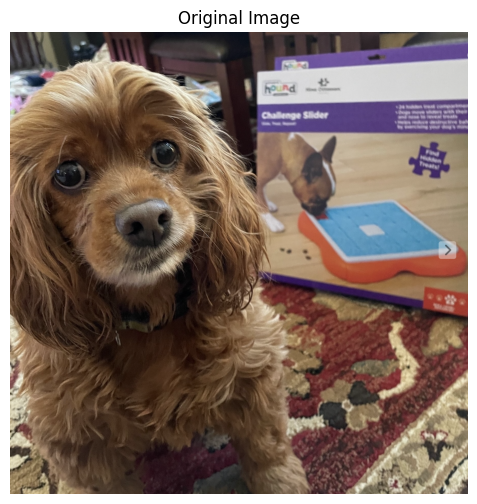

In [6]:
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [7]:
# Preprocess
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

input_tensor = transform(img).unsqueeze(0)

print("Running segmentation...")

for _ in tqdm(range(50)):   # Show progress bar!
    time.sleep(0.02)

with torch.no_grad():
    output = model_seg(input_tensor)["out"][0]

print("Segmentation complete!")

# Class predictions per pixel
mask = output.argmax(0).byte().cpu().numpy()

Running segmentation...


100%|██████████| 50/50 [00:01<00:00, 46.21it/s]


Segmentation complete!


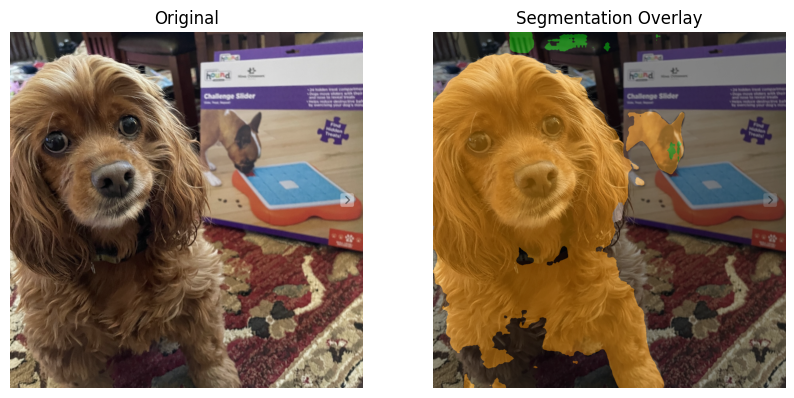

In [10]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.axis("off")
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(img)
plt.imshow(mask, alpha=0.4, cmap="nipy_spectral")  # transparent overlay
plt.axis("off")
plt.title("Segmentation Overlay")

plt.show()

In [11]:
img_np = np.array(img).astype(np.float32) / 255.0
unique_classes = np.unique(mask)
mask_resized = cv2.resize(mask.astype(np.uint8),
                          (img_np.shape[1], img_np.shape[0]),
                          interpolation=cv2.INTER_NEAREST)
print("Unique mask classes:", unique_classes)

Unique mask classes: [ 0  8  9 12 15]


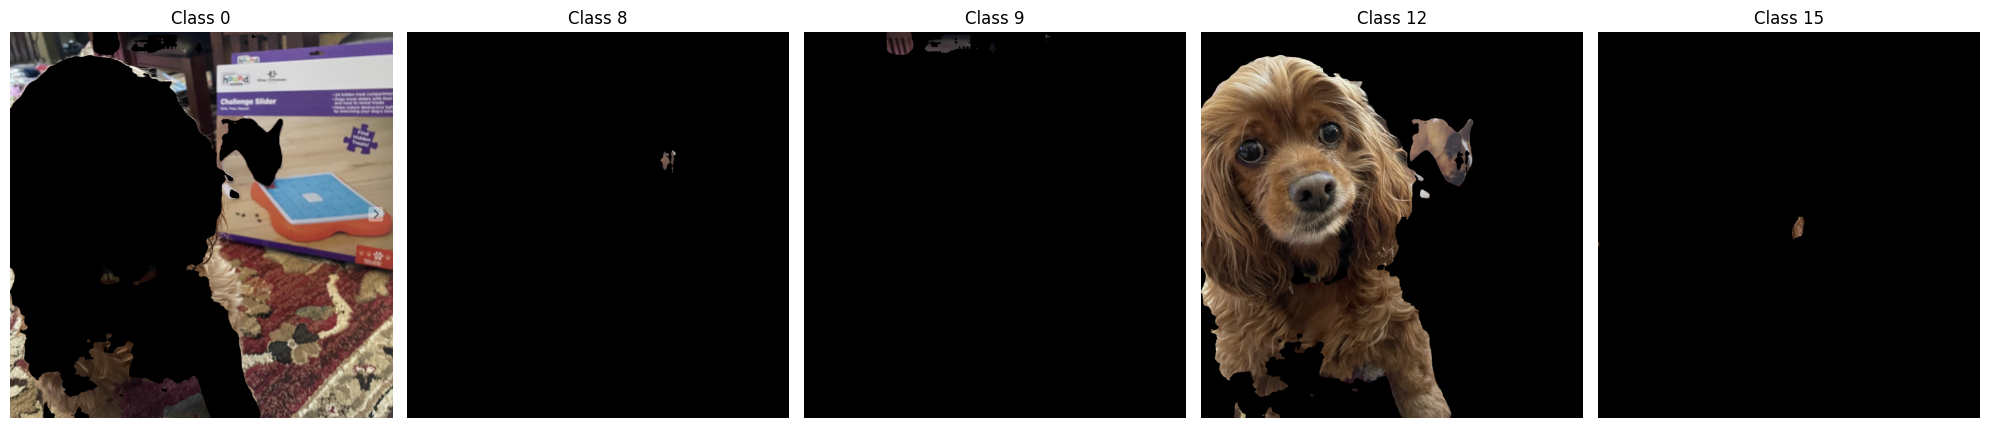

In [12]:
num_classes = len(unique_classes)
plt.figure(figsize=(4*num_classes, 5))


for i, cls in enumerate(unique_classes):
    # Blank canvas
    class_pixels = np.zeros_like(img_np)

    # Place only the class's actual pixels
    class_pixels[mask_resized == cls] = img_np[mask_resized == cls]

    plt.subplot(1, num_classes, i+1)
    plt.imshow(class_pixels)
    plt.axis("off")
    plt.title(f"Class {cls}")

plt.tight_layout()
plt.show()

# Object Detection

In [13]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [14]:
# Load pretrained YOLO model
model_img = YOLO("yolov8l.pt")  # tiny model for speed

In [15]:
# Upload or load an image
image_path = "squirrel.jpg"  # change this!
img = Image.open(image_path)

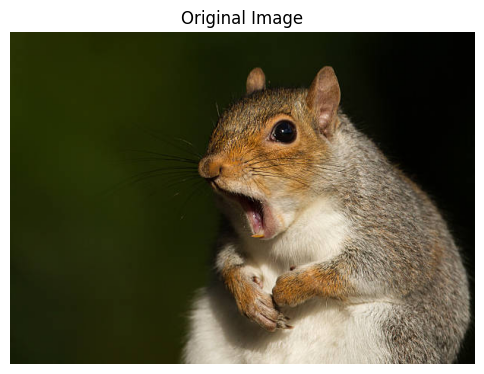

In [16]:
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [17]:
print("Running YOLOv8-L detection...")

for _ in tqdm(range(40)):
    import time; time.sleep(0.02)

results = model_img(image_path)
r = results[0]

Running YOLOv8-L detection...


100%|██████████| 40/40 [00:00<00:00, 49.01it/s]



image 1/1 /content/squirrel.jpg: 480x640 1 cat, 2065.4ms
Speed: 7.8ms preprocess, 2065.4ms inference, 19.7ms postprocess per image at shape (1, 3, 480, 640)


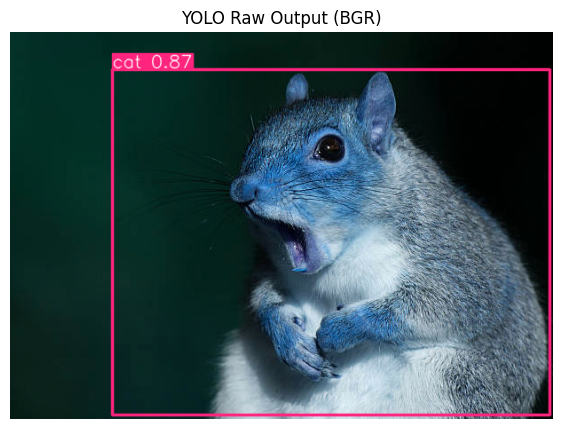

In [18]:
raw_plot = r.plot()

# Raw output
plt.figure(figsize=(7,7))
plt.imshow(raw_plot)
plt.axis("off")
plt.title("YOLO Raw Output (BGR)")
plt.show()

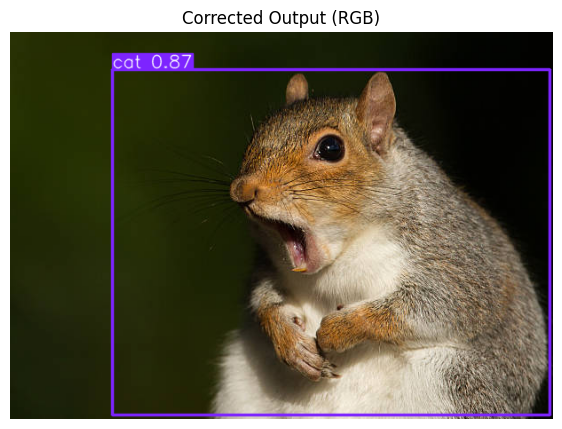

In [19]:
# Convert to RGB for correct display
rgb_plot = cv2.cvtColor(raw_plot, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7,7))
plt.imshow(rgb_plot)
plt.axis("off")
plt.title("Corrected Output (RGB)")
plt.show()

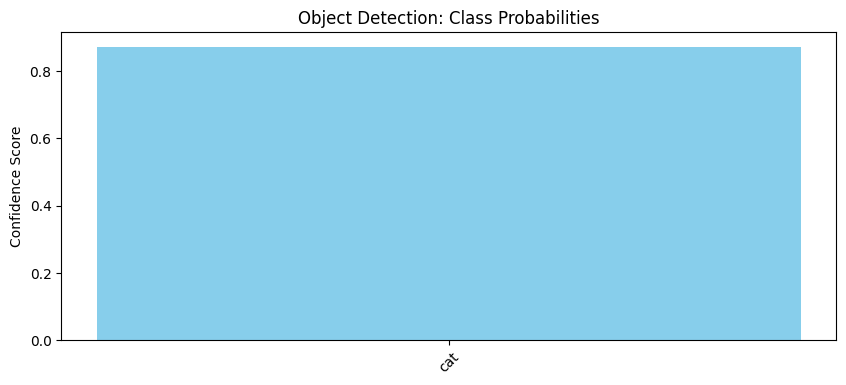

In [21]:
r = results[0]
classes = [model_img.model.names[int(box.cls)] for box in r.boxes]
scores = [float(box.conf) for box in r.boxes]

plt.figure(figsize=(10,4))
plt.bar(classes, scores, color="skyblue")
plt.ylabel("Confidence Score")
plt.title("Object Detection: Class Probabilities")
plt.xticks(rotation=45)
plt.show()